In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
train_data = pd.read_csv(r'/kaggle/input/genre-classification/train.csv')

In [ ]:
train_data['Genre'].unique()

In [ ]:
train_data['Genre'] = train_data['Genre'].str.replace('Hip-Hop', 'HipHop')

In [ ]:
train_data['Genre'].unique()

In [ ]:
genres = ['Rock', 'Jazz', 'HipHop', 'Metal', 'Country']

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # This is often needed for multilingual support
nltk.download('punkt')    # tokenizers
nltk.download('stopwords') # stopwords


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train_data = train_data[(train_data['Genre'].isin(genres)) & (train_data['Language'] == 'en')]
train_data['Lyrics'] = train_data['Lyrics'].apply(preprocess_text)

In [ ]:
train_data.to_csv('/kaggle/input/genre-classification/cleaned_train_data.csv')

In [ ]:
train_data = pd.read_csv('/kaggle/input/genre-classification/cleaned_train_data.csv')

In [ ]:
train_data.head()

,Lyrics,Genre
0,start pain followed hate fueled endless questi...,Rock
1,freedom alone alone patiently waiting phone ho...,Rock
2,biting hand feed lying voice inside reach beg ...,Rock
3,say know cant imagine wait across line thought...,Rock
4,heart beating faster cant control feeling anym...,Rock


In [ ]:
train_data['Genre'].unique()

array(['Rock', 'Metal', 'Jazz', 'HipHop', 'Country'], dtype=object)

In [ ]:
label_encoder = LabelEncoder()
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])

In [ ]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    train_data['Lyrics'],
    train_data['Genre'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['Genre']
)

In [ ]:
# Tokenizer setup
max_words_1 = 10000
max_words_2 = 25000

In [ ]:
# Prepare tokenizer for both model configurations
tokenizer = Tokenizer(num_words=max_words_1)
tokenizer.fit_on_texts(X_train)

tokenizer_2 = Tokenizer(num_words=max_words_2)
tokenizer_2.fit_on_texts(X_train)

In [ ]:
# Convert texts to sequences
X_train_seq_1 = tokenizer.texts_to_sequences(X_train)
X_train_seq_2 = tokenizer_2.texts_to_sequences(X_train)

In [ ]:
# Find the maximum sequence length for padding
max_sequence_length_1 = max([len(seq) for seq in X_train_seq_1])
max_sequence_length_2 = max([len(seq) for seq in X_train_seq_2])

In [ ]:
print("Max sequence length 1: ",max_sequence_length_1)
print("Max sequence length 2: ",max_sequence_length_2)

Max sequence length 1:  1660
Max sequence length 2:  1717


In [ ]:
# Pad sequences for both model configurations
X_train_pad_1 = pad_sequences(X_train_seq_1, maxlen=max_sequence_length_1)
X_train_pad_2 = pad_sequences(X_train_seq_2, maxlen=max_sequence_length_2)

In [ ]:
# Function to create model with variable parameters
def create_model(max_sequence_length, embedding_dim, max_words, lstm_units, num_layers=1):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
    for _ in range(num_layers - 1):
        model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dense(5, activation='softmax'))  # 5 genres
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Function to train model
def train_model(model, X_train_pad, y_train, batch_size):
    model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=10)

In [ ]:
# Function to evaluate model
def evaluate_model(model, X_val_pad, y_val):
    y_pred = np.argmax(model.predict(X_val_pad), axis=1)
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# First set of parameters (single-layer LSTM)
batch_size_1 = 4
embedding_dim_1 = 10
lstm_units_1 = 8

# Create and train the first model
model_1 = create_model(
    max_sequence_length=max_sequence_length_1,
    embedding_dim=embedding_dim_1,
    max_words=max_words_1,
    lstm_units=lstm_units_1,
    num_layers=1
)

train_model(model_1, X_train_pad_1, y_train, batch_size=batch_size_1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1128s 39ms/step - accuracy: 0.7655 - loss: 0.7163
Epoch 2/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1123s 39ms/step - accuracy: 0.8274 - loss: 0.5218
Epoch 3/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1123s 39ms/step - accuracy: 0.8457 - loss: 0.4688
Epoch 4/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1119s 39ms/step - accuracy: 0.8542 - loss: 0.4412
Epoch 5/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1125s 39ms/step - accuracy: 0.8655 - loss: 0.4134
Epoch 6/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1128s 39ms/step - accuracy: 0.8722 - loss: 0.3927
Epoch 7/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1122s 39ms/step - accuracy: 0.8795 - loss: 0.3751
Epoch 8/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1120s 39ms/step - accuracy: 0.8866 - loss: 0.3556
Epoch 9/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1120s 39ms/step - accuracy: 0.8925 - loss: 0.3416
Epoch 10/10
28744/28744 ━━━━━━━━━━━━━━━━━━━━ 1121s 39ms/step - accuracy: 0.8962 - loss: 0.3278


Evaluation of Model 1 on Test Data:
899/899 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       378
      HipHop       0.59      0.53      0.56       447
        Jazz       0.71      0.56      0.62      2663
       Metal       0.70      0.52      0.60      3827
        Rock       0.85      0.93      0.89     21429

    accuracy                           0.82     28744
   macro avg       0.57      0.51      0.54     28744
weighted avg       0.80      0.82      0.81     28744



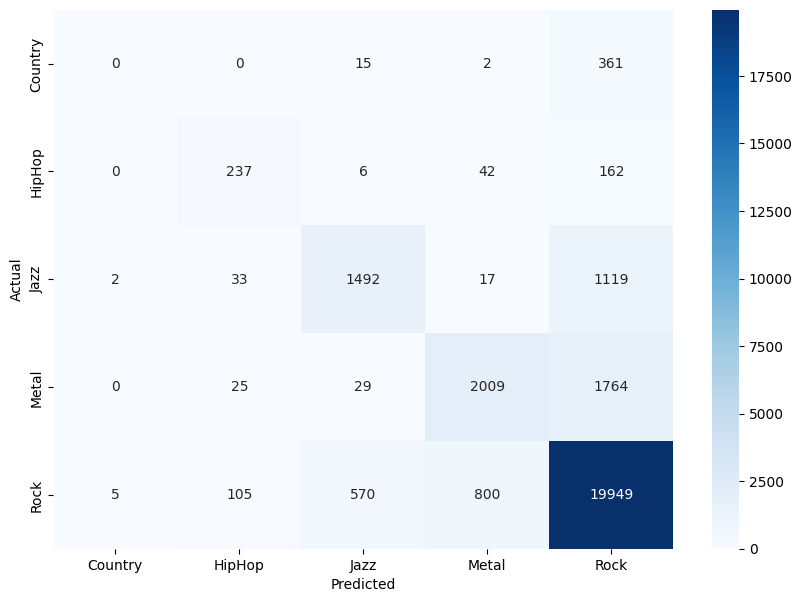

In [ ]:
# Evaluate the first model
print("Evaluation of Model 1 on Test Data:")
X_test_seq_1 = tokenizer.texts_to_sequences(X_test)
X_test_pad_1 = pad_sequences(X_test_seq_1, maxlen=max_sequence_length_1)
evaluate_model(model_1, X_test_pad_1, y_test)

In [ ]:
# Second set of parameters (two-layer LSTM)
batch_size_2 = 8
embedding_dim_2 = 30
lstm_units_2 = 16

# Create and train the second model
model_2 = create_model(
    max_sequence_length=max_sequence_length_2,
    embedding_dim=embedding_dim_2,
    max_words=max_words_2,
    lstm_units=lstm_units_2,
    num_layers=2
)

train_model(model_2, X_train_pad_2, y_train, batch_size=batch_size_2)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1119s 78ms/step - accuracy: 0.7626 - loss: 0.7302
Epoch 2/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1116s 78ms/step - accuracy: 0.8326 - loss: 0.5100
Epoch 3/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1114s 78ms/step - accuracy: 0.8574 - loss: 0.4436
Epoch 4/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1117s 78ms/step - accuracy: 0.8802 - loss: 0.3766
Epoch 5/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1116s 78ms/step - accuracy: 0.8958 - loss: 0.3237
Epoch 6/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1164s 78ms/step - accuracy: 0.9115 - loss: 0.2765
Epoch 7/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1116s 78ms/step - accuracy: 0.9234 - loss: 0.2376
Epoch 8/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1116s 78ms/step - accuracy: 0.9327 - loss: 0.2070
Epoch 9/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1116s 78ms/step - accuracy: 0.9410 - loss: 0.1826
Epoch 10/10
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 1115s 78ms/step - accuracy: 0.9481 - loss: 0.1598


Evaluation of Model 2 on Test Data:
899/899 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step
              precision    recall  f1-score   support

     Country       0.08      0.05      0.06       378
      HipHop       0.62      0.50      0.55       447
        Jazz       0.64      0.67      0.65      2663
       Metal       0.68      0.58      0.63      3827
        Rock       0.87      0.90      0.89     21429

    accuracy                           0.82     28744
   macro avg       0.58      0.54      0.56     28744
weighted avg       0.81      0.82      0.81     28744



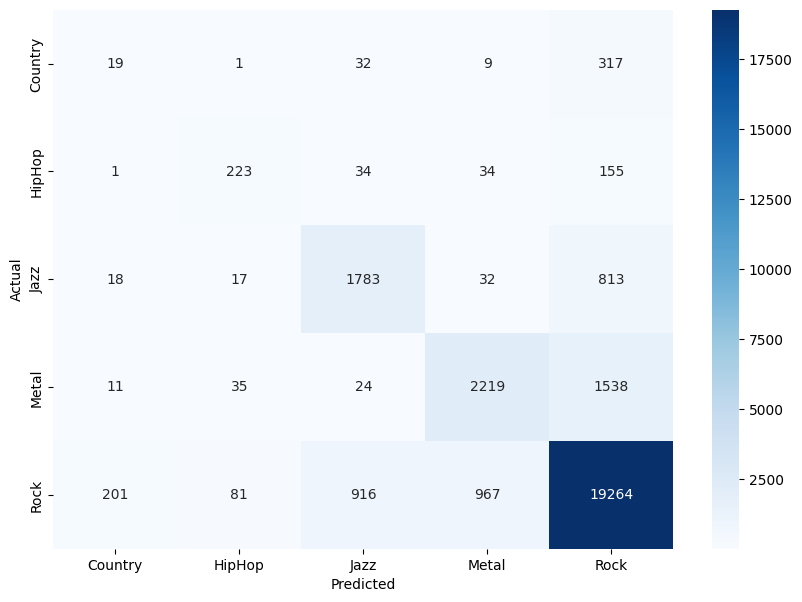

In [ ]:
# Evaluate the second model
print("Evaluation of Model 2 on Test Data:")
X_test_seq_2 = tokenizer_2.texts_to_sequences(X_test)
X_test_pad_2 = pad_sequences(X_test_seq_2, maxlen=max_sequence_length_2)
evaluate_model(model_2, X_test_pad_2, y_test)

**Conclusion:**
Model 2 slightly improves in some areas (e.g., Metal, Jazz), showing a better balance between precision and recall across the classes. The improvements in macro-average metrics also suggest Model 2 handles underrepresented classes slightly better. Both models have comparable accuracy, but Model 1 shows some issues with the "Country" class, where performance is near zero, and Model 2 slightly mitigates this.